Solution to question 4
<br> Technical Excercise - GetSetUp Data Analyst process
<br> Luis Miguel Roldan


In [1]:
# Installing libraries
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install seaborn
#!pip install pandasql
#!pip install --upgrade matplotlib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os as os
from pandasql import sqldf as sqldf

In [5]:
os.getcwd()
os.chdir('c:\\Users\\usuario\\Documents\\Documents\\gsu_exercise\\gsu_process')


In [6]:
dtype_dict = {'userid': str, 'sessionid': str, 'timestamp':str}
dtype_dict_det = { 'session_id': str, 'class_name': str, 'start_time':str, 'end_time': str}


lobby_events = pd.read_excel('data.xlsx', sheet_name='question_3_lobby_events', dtype=dtype_dict).dropna()
meeting_launch_events= pd.read_excel('data.xlsx', sheet_name='question_3_meeting_launch_event', dtype = dtype_dict)
session_details = pd.read_excel('data.xlsx', sheet_name='question_3_session_details', dtype=dtype_dict_det)

## setting the functions
pysqldf = lambda q: sqldf(q, globals())
query = '''SELECT 
    user_id,
    session_id,
    class_name,
    attendance_start_time,
    duration,
    attendance_type
FROM (
    SELECT
        user_id,
        session_id,
        class_name,
        day,
        MIN(attendance_start_time) AS attendance_start_time,
        SUM(IFNULL(duration, 0)) AS duration,
        MAX(attendance_type) AS attendance_type
    FROM (
        SELECT 
            userid AS user_id,
            session_id,
            class_name,
            day,
            datetime(init_ts, 'unixepoch') AS attendance_start_time,
            (end_ts - init_ts) / 60 AS duration,
            'lobby_attendance' AS attendance_type
        FROM (
            SELECT 
                sessionid,
                userid,
                strftime('%d', datetime(STRFTIME('%s', timestamp), 'unixepoch')) AS day,
                MAX(STRFTIME('%s', timestamp)) AS end_ts,
                MIN(STRFTIME('%s', timestamp)) AS init_ts
            FROM lobby_events
            GROUP BY sessionid, userid, day
        ) AS a 
        INNER JOIN session_details AS b ON a.sessionid = b.session_id
        
        UNION
        
        SELECT 
            userid AS user_id,
            session_id,
            class_name,
            day,
            datetime(init_ts, 'unixepoch') AS attendance_start_time,
            (end_ts - init_ts) / 60 AS duration,
            'meeting_launch' AS attendance_type
        FROM (
            SELECT 
                sessionid,
                userid,
                strftime('%d', datetime(STRFTIME('%s', timestamp), 'unixepoch')) AS day,
                MAX(STRFTIME('%s', timestamp)) AS end_ts,
                MIN(STRFTIME('%s', timestamp)) AS init_ts
            FROM meeting_launch_events
            GROUP BY sessionid, userid, day
        ) AS a 
        INNER JOIN session_details AS b ON a.sessionid = b.session_id
    ) AS a
    GROUP BY user_id, session_id, class_name, day
    ORDER BY duration DESC
) AS a;'''

data = sqldf (query)

data_plot = sqldf('''select *, case when datetime(STRFTIME('%s', end_time), 'unixepoch') < attendance_start_time then 1 else 0 end late_attendance,  (strftime('%s', attendance_start_time) - STRFTIME('%s', end_time))/60 dist from data inner join session_details sd on data.session_id = sd.session_id order by late_attendance desc''' )



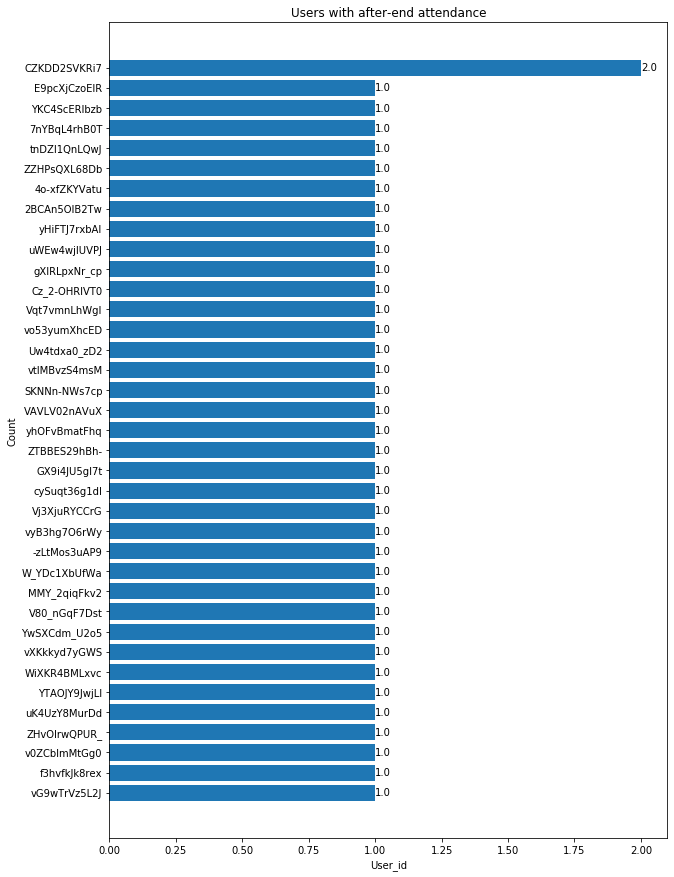

In [7]:

data_late = data_plot[data_plot["late_attendance"]>0]
late_attendance=data_late['user_id'].value_counts().sort_values (ascending = True)
late_labelsum = data_late.groupby('user_id')['dist'].sum().sort_values (ascending = True)

fig, ax = plt.subplots(figsize=(10,15))
bars = plt.barh(late_attendance.index, late_attendance.values)
ax.set_xlabel('User_id')
ax.set_ylabel('Count')
ax.set_title('Users with after-end attendance')
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.1f}', ha='left', va='center')
plt.show()


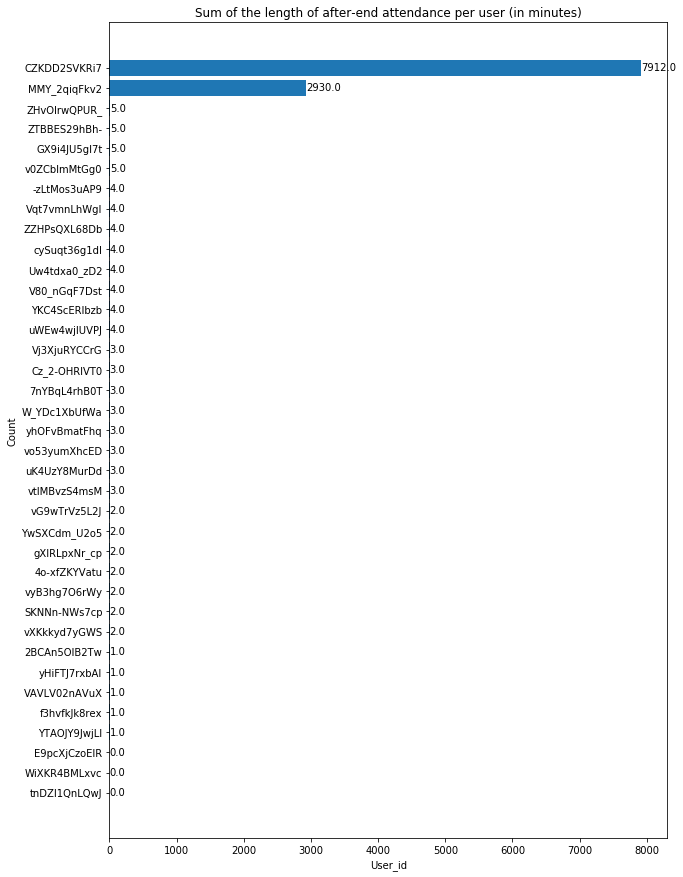

38

In [8]:
fig, ax = plt.subplots(figsize=(10,15))
bars = plt.barh(late_labelsum.index, late_labelsum.values)
ax.set_xlabel('User_id')
ax.set_ylabel('Count')
ax.set_title('Sum of the length of after-end attendance per user (in minutes)')
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.1f}', ha='left', va='center')
plt.show()
len(data_late)

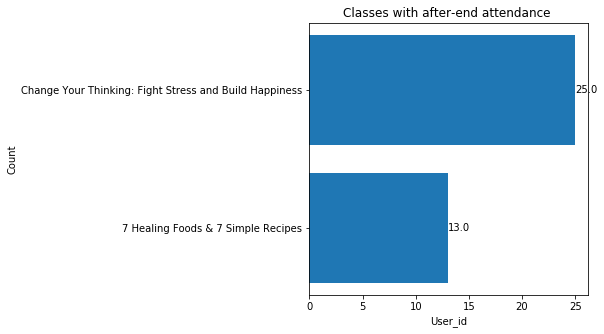

In [9]:
data_late = data_plot[data_plot["late_attendance"]>0]
late_attendance=data_late['class_name'].iloc[:,1].value_counts().sort_values (ascending = True)
late_labelsum = data_late.groupby('user_id')['dist'].sum().sort_values (ascending = True)

fig, ax = plt.subplots(figsize=(5,5
                                ))
bars = plt.barh(late_attendance.index, late_attendance.values)
ax.set_xlabel('User_id')
ax.set_ylabel('Count')
ax.set_title('Classes with after-end attendance ')
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.1f}', ha='left', va='center')
plt.show()

According to the data, 38 people joined the session after the class had finished. two of them were more than two days apart from the ending time of their ression, which could indicate a first reason for them to be joining the session after it was ended: they missed the date, and tried to join the session on a date different than the original. A second reason for joining a session after its end is to miss the hour: Since one of the courses ends at 19:00 and the other one starts at 21:00 it is likely that some of the people that joined a session after its end missed the hour of the class. Nevertheless, it is unlikely that they were the majority, because only 13 out of 38 joined too late to the class that ended earlier (7 Healing foods & 7 simple recipes).